### Extract all the files from zip

In [1]:
from zipfile import ZipFile

with ZipFile(r"C:\Users\Arya\Desktop\Data cv\dogs-vs-cats.zip") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    
with ZipFile(r"train.zip") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    
with ZipFile(r"test1.zip") as zipObj:
# Extract all the contents of zip file in current directory
    zipObj.extractall()

### Creating Directories

In [2]:
# importing os module
import os
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label sub directories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        os.makedirs(newdir, exist_ok = True)

### Now change dataset to fit above format

In [7]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed, random
seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.25

# copy training dataset images into subdirectories
src_directory = 'train'
dataset_home = 'dataset_dogs_vs_cats/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/' + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/' + file
        copyfile(src, dst)

### Prepare a model for transfer learning

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = VGG16(include_top = False, input_shape = (224,224,3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation = 'relu', kernel_initializer = 'he_uniform')(flat1)
output = Dense(1, activation = 'sigmoid')(class1)

# define new model
model = Model(inputs = model.inputs, outputs = output )

# compile model
opt = SGD(learning_rate = 0.001, momentum = 0.9)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    

58900480/58889256 [==============================] - 31s 1us/step


### Run the model using generator

In [13]:
datagen = ImageDataGenerator(featurewise_center = True)

# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', class_mode = 'binary', batch_size = 64, target_size = (224, 224))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode = 'binary', batch_size = 64, target_size = (224, 224))

# fit the model
history = model.fit_generator(train_it, steps_per_epoch = len(test_it), epochs = 1, verbose = 1)

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
99/99 [==============================] - 10921s 110s/step - loss: 0.2623 - accuracy: 0.9583


### Plot the loss and accuracy And Save the plot to file

KeyError: 'val_loss'

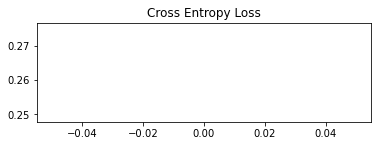

In [17]:
import matplotlib.pyplot as plt
import sys

# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color = 'b', label = 'train')
plt.plot(history.history['val_loss'], color = 'g', label = 'test')

# plot accuracy
plt.subplot(211)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color = 'b', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'g', label = 'test')

# save plot to file
filename = sys.argv[0].split('/')[-1]
plt.savefig(filename + '_plot.png')

### Saving the model

In [18]:
model.save('dogandcat_model.h5')

### Predict the output from the model

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# load and prepare the image
# load the image
model = load_model('dogandcat_model.h5')
img = load_img(r"C:\Users\Arya\dataset_dogs_vs_cats\test\dogs\dog.4.jpg", target_size = (224, 224))

# convert to array
img = img_to_array(img)

# reshape into a single sample with 3 channels
img = img.reshape(1, 224, 224, 3)

# center pixel data
img = img.astype('float32')
img = img - [123.68, 116.779, 103.939]

In [21]:
# 1 is for dogs and 0 for cats
result = model.predict(img)
print(result[0])

[1.]
